In [ ]:
import subprocess
import os
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir('/data/des41.a/data/jaortiz/snana-test/')
from python_all.parse_simlib import parse_simlib


In [2]:
#variables
t1 = 1 #time period in which we want pointing at KN to occur (days)
t2 = 28 #time period in which we are happy to do compensating swap (days)
max_airmass = 2
max_extra_slew = 70 #in deg

In [36]:
#def make_swaps():

os.chdir('/data/des41.a/data/jaortiz/snana-test/do_swaps/')
from parse_dump import findall_KN 

allKN = findall_KN()

os.chdir('/data/des41.a/data/jaortiz/snana-test/')
#copy simlib file to file new.simlib
#subprocess.call(["cp", "simlibs/minion_1016_WFD.simlib", "simlibs/new.simlib"])

#Creates a list of all pointings, with [LIBID, RA, DECL, MJD IDEXPT  FLT GAIN NOISE SKYSIG (pixels)  RATIO  ZPTAVG ZPTERR  MAG]
libid_details, pointings_arr = parse_simlib('simlibs/minion_1016_WFD.simlib')



Number of simulations:  11659


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500

****************** u Filter *********************
Number of KN processed: 11659 

Swap made: 2.5 % 
No swap made because... 
    Observation already scheduled: 1.3 %
    No observations in next 1 day(s): 92.1 %
    Swap failed as extra slew required > 70 deg: 0.4 %
    No observation in next 28 days close to KN: 3.7 %
***************************************************
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500

****************** g Filter *********************
Number of KN processed: 11659 

Swap made: 4.1 % 
No swap made because... 
    Observation already scheduled: 1.2 %
    No observations in next 1 day(s): 89.1 %
    Swap failed as extra slew required > 70 deg: 0.5 %
    No observation in next 28 days close to KN: 5.1 %
***************************************************
0
500
1000
150

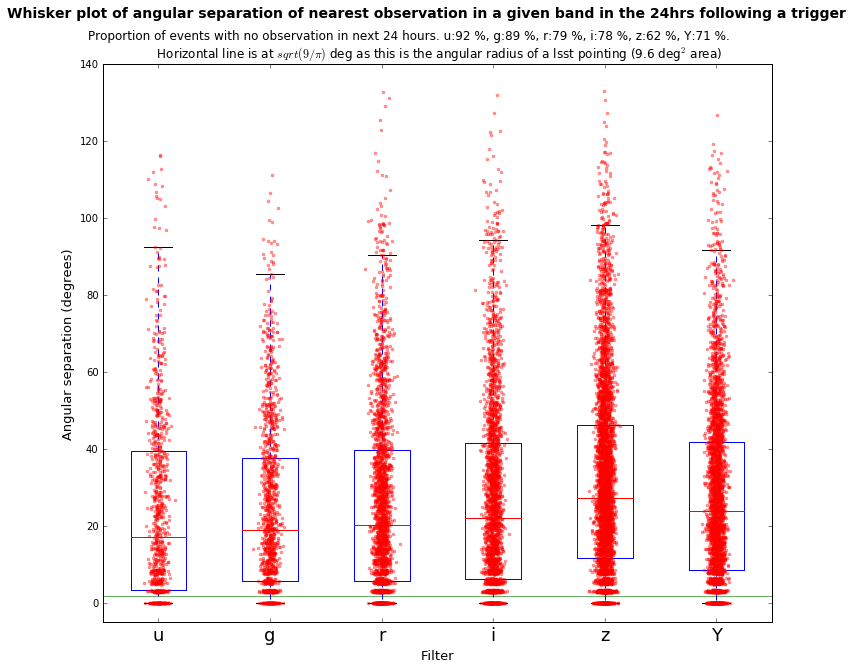

In [148]:
#Results analysis 
#[swap made, observation already scheduled, no observations in next 24hrs, slew angle >70deg, no observations in next week close to KN]

    KNlist = allKN[0:10]
    bands = ['u', 'g', 'r', 'i', 'z', 'Y']
    new_pointings_arr = np.copy(pointings_arr)

    slews = np.zeros([len(KNlist),6])
    no_obs, obs_made = np.zeros(6, dtype=float), np.zeros(6, dtype=float)

    for band in range(6):
        band_pointings_arr = pointings_arr[pointings_arr[:,5]==band, :]
        results = np.zeros(5) #must reset variable for each band
        for j, KN in enumerate(KNlist):
            if j%500 ==0:
                print j

            #when is the KN going to be visible? Check the next 24 hours in 0.5 hour intervals
            obs_times = when_observable(KN, max_airmass, t1)

            #Are we scheduled to observe this event anyway? If not find the closest observation in the next 24 hours
            closest_obs, slew_to_KN, original_overhead_time = get_closest_obs(band_pointings_arr, KN, obs_times, t1, max_extra_slew)
            slews[j, band] = slew_to_KN

            if type(original_overhead_time) == int:
                if original_overhead_time == 0:
                    results[2] += 1 #no observations in next 24hrs
                    #print 'Swap failed as no observations in next %i day(s)' %t1
                    continue
                if original_overhead_time == 1:
                    results[1] += 1 #observation already exists
                    #print 'No swap required as observation already exists with slew to KN: %f' %slew_to_KN
                    continue
                if original_overhead_time == 2:
                    results[3] += 1 #slew angle > max_extra_slew deg
                    #print 'Swap failed as closest observation has angsep: %f > 70deg' %slew_to_KN
                    continue

            #Search for future pointing at KN location (within 0.5deg) in next 7 days.
            #if we have made it this far then we want to do a swap unless there is no observation in the future we can swap with
            pointing_to_swap, min_angsep_lt = find_later_pointing(band_pointings_arr, KN, t2)
            if type(pointing_to_swap) == int:
                results[4] += 1 #note that no swap because there is no pointing close to KN in next week
                #print 'Swap failed as no observation in next %i days close to KN. Closest obs at %f' %(t2, min_angsep_lt)
                continue

            #What is the cost in slew time of swapping these pointings?
            extra_overhead_time, swap_ang = cost(pointing_to_swap, closest_obs, original_overhead_time)

            #swap libid, ra and decl 
            new_pointings_arr, results = swap_obs(new_pointings_arr, closest_obs, pointing_to_swap, results)
            results[0] += 1
            #print j, 'Swap done. t1swap= ', closest_obs[3]-KN[0], 'swap_angle= ', swap_ang

        results_perc = results*100/float(len(KNlist))
        no_obs[band] = results_perc[2] #to display this figure on graph too
        obs_made[band] = results_perc[1] 

        print '\n', '****************** %s Filter *********************' %bands[band]
        print 'Number of KN processed: %i \n' %len(KNlist)
        print 'Swap made: %.1f %% \nNo swap made because... \n    Observation already scheduled: %.1f %%' %(results_perc[0], results_perc[1])
        print '    No observations in next %i day(s): %.1f %%' %(t1,results_perc[2])
        print '    Swap failed as extra slew required > %i deg: %.1f %%' %(max_extra_slew,results_perc[3])
        print '    No observation in next %i days close to KN: %.1f %%' %(t2, results_perc[4])
        print  '***************************************************'

    data = [slews[:,0][~np.isnan(slews[:,0])], slews[:,1][~np.isnan(slews[:,1])], slews[:,2][~np.isnan(slews[:,2])], \
                 slews[:,3][~np.isnan(slews[:,3])], slews[:,4][~np.isnan(slews[:,4])], slews[:,5][~np.isnan(slews[:,5])] ]




In [3]:
def when_observable(KN, max_airmass, t1):#when is the KN going to be visible? Check the next 24 hours in 0.5 hour intervals

    lsst_location = EarthLocation(lat=-30.2446*u.deg, lon=-70.7494*u.deg, height=2663*u.m)
    utcoffset = -3*u.hour  # Chile Daylight Time
    times = np.arange(KN[0], KN[0]+t1, 1/48.) #30 minute intervals in next 24 hours
    time = Time(times, format='mjd') - utcoffset
    KN_loc = SkyCoord(ra=KN[1] * u.degree, dec=KN[2] * u.degree)
    KNaltaz = KN_loc.transform_to(AltAz(obstime=time,location=lsst_location))  
    altitude = KNaltaz.alt.deg
    
    #put limit on airmass, Could be below ~2
    zenith_ang = 90 - altitude #in deg
    zenith_ang_rad = zenith_ang * np.pi / 180
    airmass = 1 / np.cos(zenith_ang_rad)
    
    observable = (airmass<max_airmass).astype(int) #observable if altitude in sky is >5deg
    for i,t in enumerate(times):
        if 0.45 < t%1 <0.945: #must be dark. All pointings in simlib satisfy this condition
            observable[i]=0
        if airmass[i] <0:
            observable[i]=0
    
    #ind = np.nonzero(times)
    obs_times = observable*times
    ind = np.array(observable.astype(bool))
    obs_times = obs_times[ind]
    
    return obs_times 


def get_closest_obs(pointings_arr, KN, obs_times, t1, max_extra_slew):
    #Are we scheduled to observe this event anyway? If not find the closest observation in the next 24 hours

    #get pointings in the next week
    pointings_later = pointings_arr[KN[0]<pointings_arr[:,3], :]
    pointings_nextday_possible = pointings_later[pointings_later[:,3]<(KN[0]+t1)]
    
    #only consider pointings in next day when KN is observable
    if len(obs_times) == 0: #if there are no observable times then we still need to create variable pointings_nextday
        pointings_nextday = []
    else:
        for i,time in enumerate(obs_times):
            add = pointings_nextday_possible[pointings_nextday_possible[:,3]<(time+ 1/48.)]
            add = add[add[:,3]>time]
            if i==0:
                pointings_nextday = np.copy(add)
            else:
                pointings_nextday = np.vstack((pointings_nextday, add))
    
        #pointings_not_observable = [pointing for pointing in pointings_nextday_possible if pointing not in pointings_nextday]
        #print len(pointings_nextday_possible), len(pointings_not_observable), len(pointings_nextday)
        
        pointings_lcs = SkyCoord(ra=pointings_nextday_possible[:,1] * u.degree, dec=pointings_nextday_possible[:,2] * u.degree)
        KN_loc = SkyCoord(ra=KN[1] * u.degree, dec=KN[2] * u.degree)
        ags = KN_loc.separation(pointings_lcs).deg
        
        
    
    
    if len(pointings_nextday) == 0: #if no pointings in the next 24hrs, could be due to no obs_times or no pointings
        closest_obs, original_overhead_time, slew_to_KN = 0,0, np.nan
    else:
        #get angles between all of pointings and KN
        pointings_locs = SkyCoord(ra=pointings_nextday[:,1] * u.degree, dec=pointings_nextday[:,2] * u.degree)
        KN_loc = SkyCoord(ra=KN[1] * u.degree, dec=KN[2] * u.degree)
        angsep = KN_loc.separation(pointings_locs).deg
        original_overhead_time = pointings_nextday[np.argmin(angsep),3] - pointings_nextday[np.argmin(angsep)-1,3]
        
        #find closest pointing within 24hours for swap
        closest_obs = pointings_nextday[np.argmin(angsep),:]
        slew_to_KN = np.min(angsep)
        
        #check if we are scheduled to observe this event anyway
        #observations_arg = np.argwhere(angsep < np.sqrt(9.6/np.pi))
        #KN_observations = pointings_nextday[observations_arg,:] #observations made of KN, if any
        if slew_to_KN < np.sqrt(9.6/np.pi):
            original_overhead_time = 1 #no swap because observation already exists
        if slew_to_KN > max_extra_slew:
            original_overhead_time = 2 #no swap because smallest slew angle was too large

    print np.min(ags), slew_to_KN
        
    
    return closest_obs, slew_to_KN, original_overhead_time


In [ ]:

def find_later_pointing(pointings_arr, KN, t2):
    #Search for future pointing at KN location (within 0.5deg) in next 7 days.
    #if we have made it this far then we want to do a swap unless there is no observation in the future we can swap with

    #get pointings in the next week
    pointings_later = pointings_arr[KN[0]<pointings_arr[:,3], :]
    pointings_nextweek = pointings_later[pointings_later[:,3]<(KN[0]+t2)]
    
    nextweek_locs = SkyCoord(ra=pointings_nextweek[:,1] * u.degree, dec=pointings_nextweek[:,2] * u.degree)
    KN_loc = SkyCoord(ra=KN[1] * u.degree, dec=KN[2] * u.degree)
    angsep_longterm = KN_loc.separation(nextweek_locs).deg
    min_angsep_lt = np.min(angsep_longterm)
    if np.min(angsep_longterm) > np.sqrt(9.6/np.pi): #Require KN to be inside observation as we will swap ra,decl
        pointing_to_swap = 0 #no observations in next week to swap with
    else:
        possible_swap_arg = np.argwhere(angsep_longterm < np.sqrt(9.6/np.pi)) 
        pointing_to_swap = pointings_nextweek[possible_swap_arg,:][0][0] #get pointing to swap
        
    return pointing_to_swap, min_angsep_lt




def cost(pointing_to_swap, closest_obs, original_overhead_time):
    #What is the cost in slew time of swapping these pointings?

    swap_to_now = SkyCoord(ra=closest_obs[1] * u.degree, dec=closest_obs[2] * u.degree)
    swap_to_later = SkyCoord(ra=pointing_to_swap[1] * u.degree, dec=pointing_to_swap[2] * u.degree)
    swap_angle = swap_to_now.separation(swap_to_later).deg 
    const1, const2 = 23/(24*3600.), 1.1/(24*3600.) #these numbers must be changed
    new_overhead_time = const1 + const2*swap_angle
    extra_overhead_time = new_overhead_time - original_overhead_time #units of days

    return extra_overhead_time, swap_angle


def swap_obs(new_pointings_arr, closest_obs, pointing_to_swap, results): #swap libid, ra and decl 
    
    for i in range(len(new_pointings_arr)):
        if new_pointings_arr[i,4]==closest_obs[4]:
            new_pointings_arr[i,0:3] = pointing_to_swap[0:3]
        if new_pointings_arr[i,4]==pointing_to_swap[4]:
            new_pointings_arr[i,0:3] = closest_obs[0:3]

    return new_pointings_arr, results